## Установка необходимых для работы библиотек
Необходимо выбрать `GPU` runtime type в настройках `runtime` google colab.
Обратите внимание, что установка может занять несколько минут (обычно 5 минут).

In [ ]:
!pip install torch torchvision
!pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'
!pip install celluloid
!pip install tqdm

## Загрузка библиотек

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# You should work in Jupyter.
from tqdm import tqdm_notebook

from celluloid import Camera

import torch

# untilitis 
from pytorch3d.utils import ico_sphere

# loss functions and regulaziers
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency
)

# io utils
from pytorch3d.io import load_obj

# operations with data
from pytorch3d.ops import sample_points_from_meshes

# datastructures
from pytorch3d.structures import Meshes, Textures

# render 
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras,
    DirectionalLights, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    HardPhongShader
)


In [2]:
# If you have got a CUDA device, you can use GPU mode
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  torch.cuda.set_device(device)
else:
  device = torch.device('cpu')

Загрузка полигональной модели `bunny.obj` с сайта [Stanford graphics](https://graphics.stanford.edu/~mdfisher/Data/Meshes/bunny.obj), в случае, если работаем в colab.

In [ ]:
!mkdir data

In [ ]:
!wget -nc -P ./data/ https://graphics.stanford.edu/~mdfisher/Data/Meshes/bunny.obj

In [16]:
path_to_model = os.path.join("data","bunny.obj")

# Подготовка моделей

In [17]:
# Bunny mesh in pytorch3d
verts, faces_idx, _ = load_obj(path_to_model)
faces = faces_idx.verts_idx

center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)

textures = Textures(verts_rgb=verts_rgb.to(device))

# Create a Meshes object for the bunny.
bunny_mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)], 
    textures=textures
)

# Sphere mesh in pytorch3d
sphere_mesh = ico_sphere(4, device)
verts_rgb = torch.ones_like(sphere_mesh.verts_list()[0])[None]
sphere_mesh.textures = Textures(verts_rgb=verts_rgb.to(device))

In [18]:
# Mesh to pointcloud with normals in pytorch3d
num_points_to_sample = 25000

bunny_vert, bunny_norm = sample_points_from_meshes(
    bunny_mesh,
    num_points_to_sample ,
    return_normals=True
)

sphere_vert, sphere_norm = sample_points_from_meshes(
    sphere_mesh,
    num_points_to_sample,
    return_normals=True
)

# Подготовка рендеринга полигональных моделей

In [9]:
# Initialize an OpenGL perspective camera.
cameras = OpenGLPerspectiveCameras(device=device)

# We will also create a phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=1024, 
    blur_radius=0, 
    faces_per_pixel=1, 
)

# We can add a directional light in the scene. 
ambient_color = torch.FloatTensor([[0.0, 0.0, 0.0]]).to(device)
diffuse_color = torch.FloatTensor([[1.0, 1.0, 1.0]]).to(device)
specular_color = torch.FloatTensor([[0.1, 0.1, 0.1]]).to(device)
direction = torch.FloatTensor([[1, 1, 1]]).to(device)
lights = DirectionalLights(ambient_color=ambient_color,
                           diffuse_color=diffuse_color,
                           specular_color=specular_color,
                           direction=direction,
                           device=device)

phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(
        device=device, 
        cameras=cameras, 
        lights=lights
        )
)

# Select the viewpoint using spherical angles  
distance = 2.0   # distance from camera to the object`
elevation = 40.0   # angle of elevation in degrees
azimuth = 0.0  # No rotation so the camera is positioned on the +Z axis. 

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device,at=((-0.02,0.1,0.0),))

In [24]:
# Select the viewpoint using spherical angles  
distance = 2.0   # distance from camera to the object`
elevation = 40.0   # angle of elevation in degrees
azimuth = 0.0  # No rotation so the camera is positioned on the +Z axis. 

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device,at=((-0.02,0.1,0.0),))

# Render the bunny providing the values of R and T. 
image_bunny = phong_renderer(meshes_world=bunny_mesh, R=R, T=T)
image_sphere = phong_renderer(meshes_world=sphere_mesh, R=R, T=T)

image_sphere = image_sphere.cpu().numpy()
image_bunny = image_bunny.cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


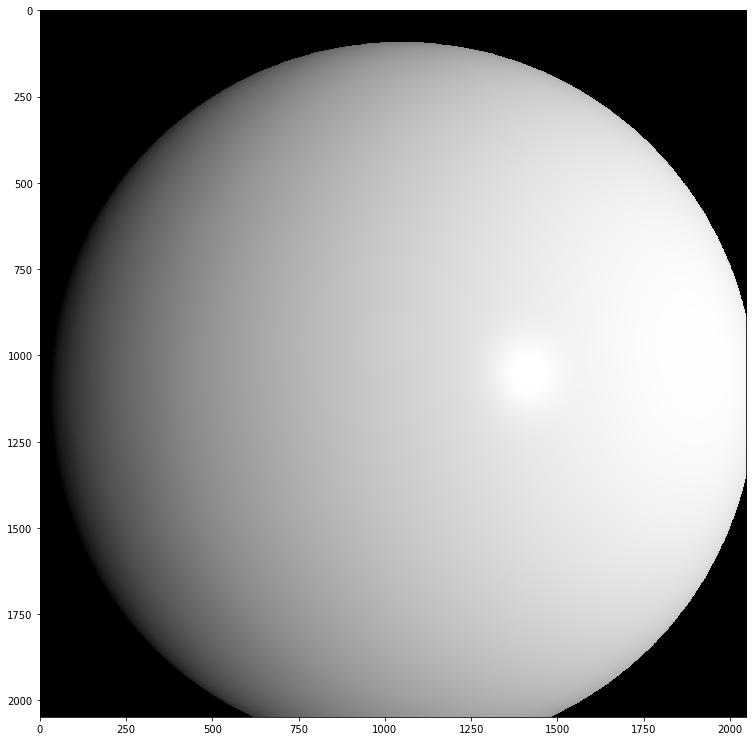

In [25]:
# Source mesh of sphere
plt.figure(figsize=(13, 13))
plt.imshow(image_sphere.squeeze())
plt.grid(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


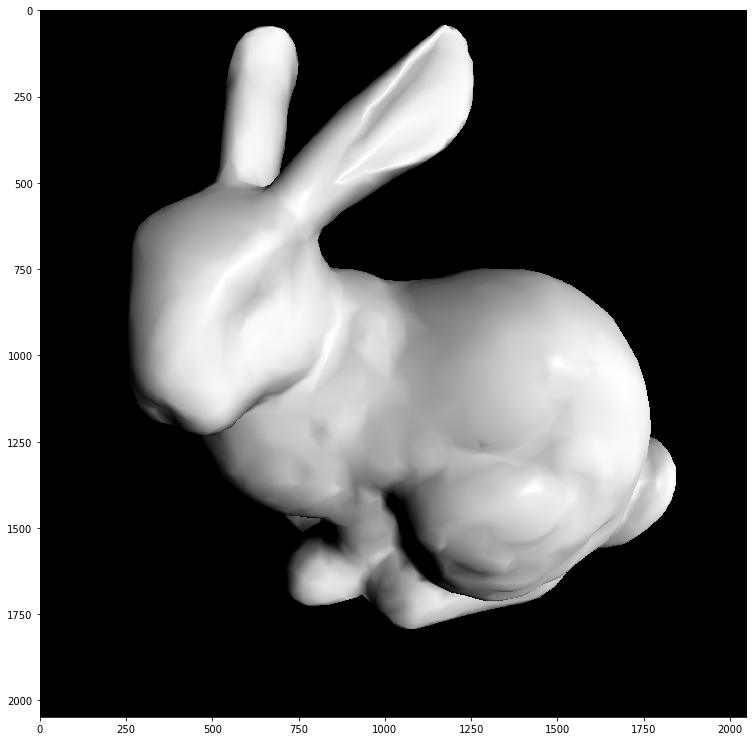

In [26]:
# Target mesh of bunny
plt.figure(figsize=(13, 13))
plt.imshow(image_bunny.squeeze())
plt.grid(False)

# Вычисление метрик и регуляризаторов

## Вычисление метрик *chamfer loss* и *normal loss*.

In [19]:
# Chamfer loss and normal loss
loss_chamfer, loss_normals_chamfer = chamfer_distance(
    bunny_vert, 
    sphere_vert, 
    x_normals=bunny_norm,
    y_normals=sphere_norm
)

In [20]:
print("Chamfer loss =", loss_chamfer.item())
print("Normal loss =", loss_normals_chamfer.item())

Chamfer loss = 0.2609584927558899
Normal loss = 0.47336119413375854


## Вычисление различных регуляризаторов.

In [21]:
print("Edge loss for bunny.obj:", mesh_edge_loss(bunny_mesh).item())
print("Edge loss for sphere.obj:", mesh_edge_loss(sphere_mesh).item())

Edge loss for bunny.obj: 0.004127349238842726
Edge loss for sphere.obj: 0.005724199116230011


In [22]:
print("Laplacian smoothing objective for bunny.obj:", mesh_laplacian_smoothing(bunny_mesh).item())
print("Laplacian smoothing objective for sphere.obj:", mesh_laplacian_smoothing(sphere_mesh).item())

Laplacian smoothing objective for bunny.obj: 0.014459558762609959
Laplacian smoothing objective for sphere.obj: 0.0040009506046772


In [23]:
print("Smooth regularizer for bunny.obj:", mesh_normal_consistency(bunny_mesh).item())
print("Smooth regularizer for sphere.obj:", mesh_normal_consistency(sphere_mesh).item())

Smooth regularizer for bunny.obj: 0.03854169696569443
Smooth regularizer for sphere.obj: 0.0009780693799257278


# Деформации сферы в кролика

Задаем оптимизируемые параметры и сам оптимизатор.

In [ ]:
deform_verts = torch.full(sphere_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

Устанавливаем параметры для процесса оптимизации.

In [ ]:
# Number of optimization steps
Niter = 1001
# Weight for the chamfer loss
w_chamfer = 1.0 
# Weight for mesh edge loss
w_edge = 1.0 
# Weight for mesh normal consistency
w_normal = 0.01 
# Weight for mesh laplacian smoothing
w_laplacian = 0.1 
# Plot period for the losses
plot_period = 50

chamfer_losses = []
laplacian_losses = []
edge_losses = []
normal_losses = []

В цикле будем делать градиентный спуск по функции потерь, представляющей из себя взвешенную сумму функций ошибок и регуляризаторов.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

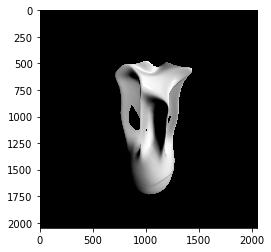

In [10]:
loop = tqdm_notebook(range(Niter))

%matplotlib inline
fig = plt.figure()
camera = Camera(fig)


for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    new_src_mesh = sphere_mesh.offset_verts(deform_verts)
    
    # We sample 5k points from the surface of each mesh 
    sample_trg = sample_points_from_meshes(bunny_mesh, 5000)
    sample_src = sample_points_from_meshes(new_src_mesh, 5000)
    
    # We compare the two sets of pointclouds by computing (a) the chamfer loss
    loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)
    
    # and (b) the edge length of the predicted mesh
    loss_edge = mesh_edge_loss(new_src_mesh)
    
    # mesh normal consistency
    loss_normal = mesh_normal_consistency(new_src_mesh)
    
    # mesh laplacian smoothing
    loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")
    
    # Weighted sum of the losses
    loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian
    
    # Print the losses
    loop.set_description('total_loss = %.6f' % loss)
    
    # Save the losses for plotting
    chamfer_losses.append(loss_chamfer)
    edge_losses.append(loss_edge)
    normal_losses.append(loss_normal)
    laplacian_losses.append(loss_laplacian)
    

    # Plot mesh
    if i % plot_period == 0 or i==0:

        # Render the bunny providing the values of R and T. 
        image_bunny = phong_renderer(meshes_world=new_src_mesh, R=R, T=T)
        image_bunny = image_bunny.detach().cpu().numpy()

        plt.imshow(image_bunny.squeeze())
        plt.grid(False)
        camera.snap()

        
    # Optimization step
    loss.backward()
    optimizer.step()

Сохраним анимацию процесса деформации.

In [11]:
animation = camera.animate()
animation.save('deformation_animation.mp4')

Визуализируем изменение функций потерь и регуляризаторов в процессе оптимизации.

Text(0.5, 1.0, 'Loss vs iterations')

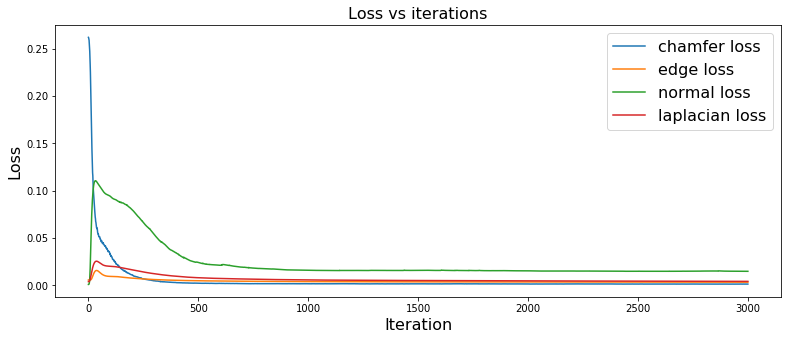

In [13]:
# Losses evaluation
fig = plt.figure(figsize=(13, 5))
ax = fig.gca()
ax.plot(chamfer_losses, label="chamfer loss")
ax.plot(edge_losses, label="edge loss")
ax.plot(normal_losses, label="normal loss")
ax.plot(laplacian_losses, label="laplacian loss")
ax.legend(fontsize="16")
ax.set_xlabel("Iteration", fontsize="16")
ax.set_ylabel("Loss", fontsize="16")
ax.set_title("Loss vs iterations", fontsize="16")